# NAMD study of pristine MoS2

This notebook will do the NA-MD calculations and all the needed analysis for you. You just need to generate suitable input data, place it in correct places, and select appropriate parameters for the simulations below.

------------------------
Import all the definitions

In [1]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.decoherence_times as decoherence_times
from libra_py import data_conv
from libra_py import data_stat
from libra_py import data_outs
from libra_py import fit
from libra_py import influence_spectrum as infsp


import matplotlib.pyplot as plt   # plots
import numpy as np
from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24",
              "11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24",
              "11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"
             ]


def plot_map(ax, energy, X):
    
    colormap =  "plasma" # "Blues" # options: plasma, viridis, binary, hot, etc.
    
    npts = len(energy)
    
    emin = energy[0]
    emax = energy[npts-1]
    
    extent=(emin, emax, emin, emax)
    
    xs0, ys0, zs0 = [], [], []

    for i in xrange(npts):    
        for j in xrange(npts):
            xs0.append(energy[i])
            ys0.append(energy[j])
            zs0.append(X[i][j])

    N = 30j
    xs,ys = np.mgrid[extent[0]:extent[1]:N, extent[2]:extent[3]:N]
    zs = griddata(xs0, ys0, zs0,  xs, ys, interp="linear")

    #ax.xticks(energy, rotation=30)
    #ax.yticks(energy, rotation=30)    
    
    ax.xticks(rotation=30)
    ax.yticks(rotation=30)
            
    ax.imshow(zs.T, cmap=colormap, extent=extent, interpolation='Lanczos', origin='lower')
    ax.plot(xs0, ys0, "ro")
    ax.colorbar()

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<in

## 1. Get Data 

Read in all the data sets. Form the sub-Hamiltonians for all data set (active space)

The data in traj1_out_pyxaid should have been generated by another notebook.

In [2]:
params = {}

# Folders with data sets
params["data_set_paths"] = ["traj1_out_pyxaid/"]

# How many files in each folder
params["nfiles"] = 2600

# Prefix of the files with energies (re) and couplings (im)
params["Hvib_re_prefix"] = "Hvib_"
params["Hvib_im_prefix"] = "Hvib_"

# Suffix of the files with energies (re) and couplings (im)
params["Hvib_re_suffix"] = "_re"
params["Hvib_im_suffix"] = "_im"

# The number of lines/cols in each file
params["nstates"] = 7

# Select the active states
params["active_space"] = range(0,7)


Hvib = step4.get_Hvib2(params)
T = [i for i in xrange(len(Hvib[0])) ]

Visualize the couplings and energies of all the states (SD states defined in another notebook)

Also, compute the distributions of the energies and couplings to see their variabiability in the MD

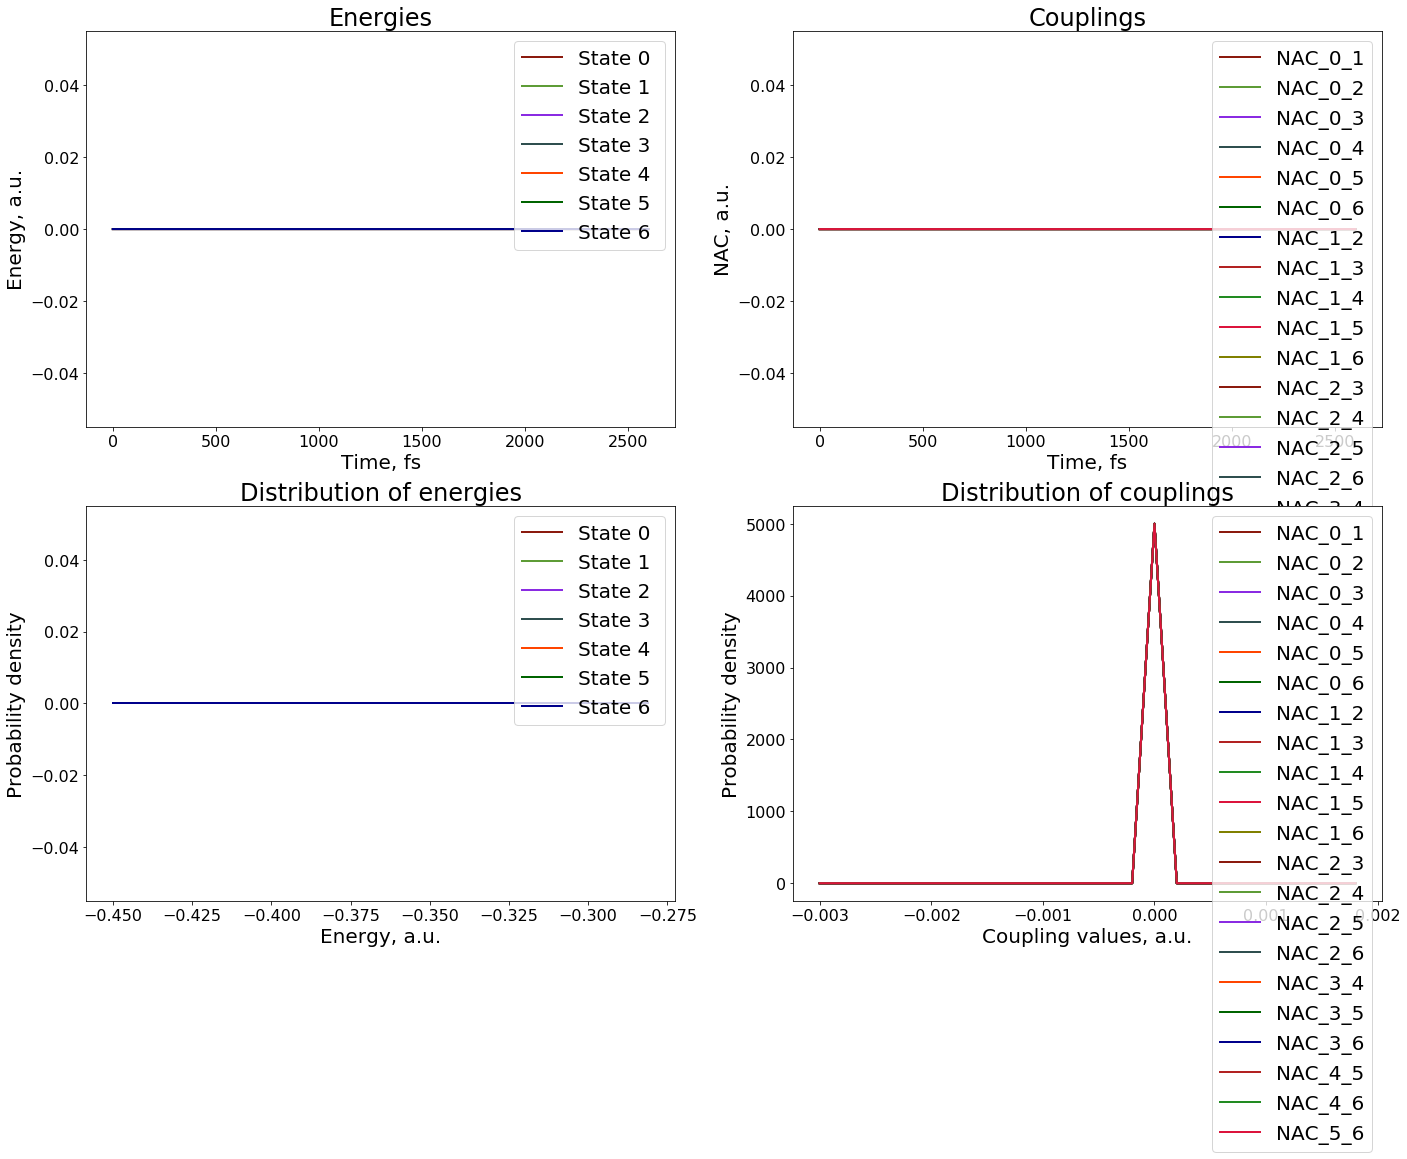

In [3]:
states = [0, 1, 2, 3, 4, 5, 6]
nst = len(states)

plt.figure(1, figsize=(24, 16)) # dpi=300, frameon=False)
plt.subplot(2,2,1)
plt.title('Energies')
plt.xlabel('Time, fs')
plt.ylabel('Energy, a.u.')
for i in xrange(nst):
    st = states[i]
    En = data_conv.unpack1(Hvib[0], st, st, 0)    
    plt.plot(T, En, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,2)
plt.title('Couplings')
plt.xlabel('Time, fs')
plt.ylabel('NAC, a.u.')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        NAC = data_conv.unpack1(Hvib[0], st1, st2, 1)
        plt.plot(T, NAC, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]]) 
        cnt = cnt + 1
plt.legend()


plt.subplot(2,2,3)
plt.title('Distribution of energies')
plt.xlabel('Energy, a.u.')
plt.ylabel('Probability density')

for i in xrange(nst):
    st = states[i]
    bin_supp, dens, cum = data_stat.cmat_distrib(Hvib[0], st, st, 0, -0.45, -0.28, 0.001)    
    plt.plot(bin_supp, dens, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(2,2,4)
plt.title('Distribution of couplings')
plt.xlabel('Coupling values, a.u.')
plt.ylabel('Probability density')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        bin_supp, dens, cum = data_stat.cmat_distrib(Hvib[0], st1, st2, 1, -0.003, 0.002, 0.0002)    
        plt.plot(bin_supp, dens, label='NAC_%i_%i' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]])     
        cnt = cnt + 1
plt.legend()

plt.show()
plt.close()

Also, compute the map of the averaged couplings and plot it as a 2D picture

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.


ValueError: x and y arrays must consist of at least 3 unique points

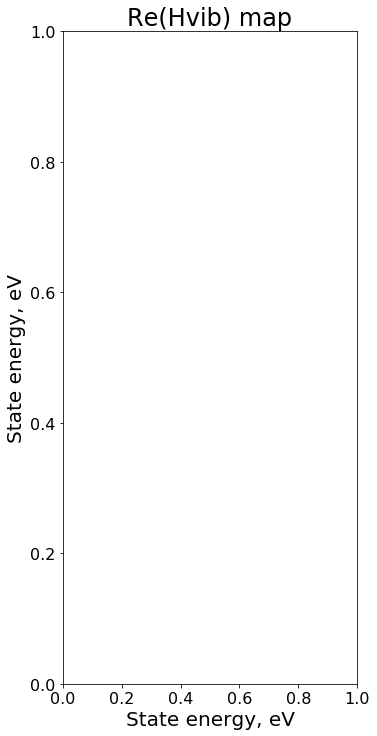

In [4]:
opt = 2
Hvib_ave = data_stat.cmat_stat2(Hvib[0], opt)

x, y, Hvib_data_re = data_outs.show_matrix_pyplot(Hvib_ave.real(), 0)
x, y, Hvib_data_im = data_outs.show_matrix_pyplot(Hvib_ave.imag(), 0)

# Energy axis in eV
e = []
sz = Hvib_ave.num_of_cols
for i in xrange(sz):
    e.append(Hvib_ave.get(i,i).real * units.au2ev)
        

plt.figure(1, figsize=(12, 12)) # dpi=300, frameon=False)
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels


plt.subplot(1,2,1)
plt.title('Re(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hvib_data_re)


plt.subplot(1,2,2)
plt.title('Im(Hvib) map')
plt.xlabel('State energy, eV')
plt.ylabel('State energy, eV')
plot_map(plt, e, Hvib_data_im)

plt.show()
plt.close()

## 2. Decoherence Times

Compute decoherence times based on the energy gap fluctuations

In [ ]:
itimes = [0]
nsteps = len(Hvib[0])
verbosity = 0
tau, rates = decoherence_times.decoherence_times_ave(Hvib, itimes, nsteps, verbosity)

nst = Hvib[0][0].num_of_cols
for i in xrange(nst):
    for j in xrange(i+1, nst):
        print "tau-%i-%i = " % (i,j), tau.get(i,j) * units.au2fs, " fs"

## 3. Influence Spectrum

Compute energy gaps, averaged (<dE^2>) over the trajectories and time

In [ ]:
dE = decoherence_times.energy_gaps_ave(Hvib, itimes, nsteps)

Compute the distributions of energy gaps and plot them

In [ ]:
states = [0, 1, 2, 3, 4, 5, 6]
nst = len(states)

plt.figure(1, figsize=(9, 6)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Distribution of energy gaps')
plt.xlabel('Energy gaps, a.u.')
plt.ylabel('Probability density')
cnt = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1, nst):
        st2 = states[j]        
        bin_supp, dens, cum = data_stat.cmat_distrib(dE, st1, st2, 0, 0.0, 0.025, 0.001)    
        plt.plot(bin_supp, dens, label='|E(%i)-E(%i)|' % (st1, st2), linewidth=2, color = colors[clrs_index[cnt]])     
        cnt = cnt + 1
plt.legend()

plt.show()
plt.close()

Now, lets select the energy window of interest and compute the influence spectrum to see which phonons are coupled to which transitions.

In [ ]:
params = {}
params["dt"] = 1.0        # MD timestep in fs
params["wspan"] = 500.0  #  cm^-1
params["dw"] = 1.0        # cm^-1
params["do_output"] = False
params["do_center"] = True
params["acf_type"] = 1
params["data_type"] = 0


In [ ]:
states = [0, 1, 2, 3, 4]
nst = len(states)

ACF, W, J2 = [], [], []
for i in xrange(nst):
    for j in xrange(i+1,nst):
        
        data_ij = []        
        for de in dE:
            x = MATRIX(1,1)
            x.set(0,0, de.get(i,j))
            data_ij.append(x)

        Tij, ACFij, uACFij, Wij, Jij, J2ij = infsp.recipe1(data_ij, params)
        
        ACF.append(ACFij)
        W.append(Wij)
        J2.append(J2ij)

Visualize the computed influence spectrum as well as the ACFs

In [ ]:
plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('ACF')
plt.xlabel('Time, fs')
plt.ylabel('ACF')
count = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1,nst):
        st2 = states[j]
        
        plt.plot(T, ACF[count], label='ACF for gap %i - %i' % (st1, st2), linewidth=2, color = colors[clrs_index[count]]) 
        count = count + 1
plt.legend()


plt.subplot(1,2,2)
plt.title('Influence Spectrum')
plt.xlabel('Frequency, cm^-1')
plt.ylabel('|J|^2')
count = 0
for i in xrange(nst):
    st1 = states[i]
    for j in xrange(i+1,nst):
        st2 = states[j]        
        plt.plot(W[count], J2[count], label='Influence spectrum for gap %i - %i' % (st1, st2), linewidth=2, color = colors[clrs_index[count]]) 
        count = count + 1
plt.legend()

plt.show()
plt.close()

## 4. Nonadiabatic Dynamics 

Define simulation parameters

In [ ]:
params = {}

# Trajectory:
params["dt"] = 41.0  # in a.u. of time

# Thermals:
params["T"] = 300.0           # in K
params["Boltz_opt"] = 1       # options: 0 (no), 1 (Pyxaid), 2 (Classical), 3 (N-state Boltzmann)

# Statistics:
params["ntraj"] = 1000

# TSH:
params["sh_method"] = 1       # 0 - MSSH, 1 - FSSH

# Decoherence:
params["decoherence_constants"] = 0   # 0 - decoherence times from the data
params["decoherence_method"] = 2      # 0 (no), 1 (ID-A), 2 (mSDM), 3 (DISH)

# Simulation:
params["istate"] = 1
params["init_times"] = [0, 50, 100, 150, 200, 250]
params["nsteps"] = 1000   # can not be larger than len(Hvib)

# Outputs:
params["outfile"] = "_out.txt"

Run the actual calculations

In [ ]:
res = step4.run(Hvib, params)

Visualize the population dynamics

In [ ]:
# nstates = 2 => n_cols = 2*3 + 5 = 10
#        0    1      2     3    4      5      6     7     8    9   10
# res =  t  E0, P_SE0, P_SH0, E1, P_SE1, P_SH1, E_SE, E_SH, P_SE, P_SH

T = [i*params["dt"]*units.au2fs for i in xrange(params["nsteps"]) ]

states = [0, 1, 2, 3, 4, 5, 6]
nst = len(states)

plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('SE populations')
plt.xlabel('Time, fs')
plt.ylabel('Population')
for i in xrange(nst):
    st = states[i]
    Pi = data_conv.unpack2(res, 1+ 3*st+1)    
    plt.plot(T, Pi, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.subplot(1,2,2)
plt.title('SH populations')
plt.xlabel('Time, fs')
plt.ylabel('Population')
for i in xrange(nst):
    st = states[i]
    Pi = data_conv.unpack2(res, 1+ 3*st+2)    
    plt.plot(T, Pi, label='State %i ' % (st), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()

plt.show()
plt.close()

Lets do the fitting of the initial excited state decay curve. The fitting gives about 160 fs for the decay time. From the population dynamics plots above, one can see that the population transfers to other, energetically close states, but the recombination doesn't happen, or at least it is not observed.

In [ ]:
st = 1
P_st = data_conv.unpack2(res, 1+ 3*st+2)    

verb, opt = 0, 0
Pfit1, A1, B1 = fit.fit_exp(T, P_st, 0.0, verb, opt)  
print "SLG data gives: A = ", A1, " and B = ", B1, " 1/B = ", 1/B1, " fs"

plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Fitting')
plt.xlabel('Time, fs')
plt.ylabel('Population')

plt.plot(T, P_st, label='State %i ' % (st), linewidth=2, color = colors["11"]) 
plt.plot(T, Pfit1, label='State %i ' % (st), linewidth=2, color = colors["21"]) 

plt.legend()

## 5. X-NA-MD 

Ok, after the initial test, we see that the recovery of the ground state is very slow, so we can't get reliable timescales if we just do the direct fitting of the computed populations (they are not zero, but very small). Instead, we are going to use the artificial scaling of the couplings by a parameter $\alpha$ which will then be varied. 

Lets define an auxiliary function that will:

* scale the input NACs by the given parameter $\alpha$
* run the NA-MD calculations for all possible initial excitations
* save the results of the dynamics in the files, in case we don't want to recompute it all again
* compute the population of the ground state over all initial excitation as a function of time
* rescale the NACs back - to the original value
* return the averaged population of the ground state vs. time

In [ ]:
def run_scaling(hvib, alp, prms):
    # Scale NACS
    data_conv.scale_NACs(hvib, alp)
    
    P_ave = []
    for i in xrange(params["nsteps"]):
        P_ave.append(0.0)
    
    # Change already defined NA-MD parameters    
    istates = range(1,7)  # possible initial excitations
    nrm = 1.0/len(istates)
    
    for istate in istates:
        prms["istate"] = istate    
        params["outfile"] = "_out-scl%5.3f-istate%3i.txt" % (alp, istate)
    
        res = step4.run(Hvib, prms)
    
        # Extract the population of the Ground state
        P0 = data_conv.unpack2(res, 2)    
        
        for i in xrange(params["nsteps"]):
            P_ave[i] = P_ave[i] + nrm*P0[i]
    
    # Return the NACs to the original values
    data_conv.scale_NACs(hvib, (1.0/alp))
    
    return P_ave

Now, we are about to start the actual calculations. Since this may be a bit time-consuming, I'm going to reduce the cost-influencing parameters - only 100 surface hopping trajectories per 1 initial condition (initial time and initial excitation)

We will use 6 initial times, to represent the sampling of the initial conditions

The NA-MD will be run for just 1 ps.

In [ ]:
params["ntraj"] = 100
params["init_times"] = [0, 50, 100, 150, 200, 250]
params["nsteps"] = 1000   # can not be larger than len(Hvib)

Now, we are going to run NA-MD with different scaling parameter $\alpha$ taking one of the following 6 values.

We are interested only in the population of the ground state, so lets save each population dataset in the variable P_alpha for future use.

BEWARE: this step may take a while (several minutes in my case)!!! it produces a bunch of output files too 

In [ ]:
alphas = [1.0, 5.0, 10.0, 20.0, 50.0, 100.0]
P_alpha = []

for alp in alphas:
    pi = run_scaling(Hvib, alp, params)
    P_alpha.append(list(pi))

Lets plot the total population of all excited states (1 - population of the ground state). 

Lets fit each such data to an exponential decay function.

The function prints out the recombination times computed for each scaling parameter. 

Empirically, I have determined that the scaling parameter of 100 was too much, so we exclude it from our analysis.

In this step, we also collect all the times and rates (inverse timese) obtained from the fitting - these data will be used later on.

Also, note that the direct estimate of the recombination rate (corresponding to $\alpha = 1$) yields the timescale of 1.34 ns

In [ ]:
plt.figure(1, figsize=(24, 16)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Population decay')
plt.xlabel('Time, fs')
plt.ylabel('Population')

tau, inv_tau = [], []

n_alphas = len(alphas)
for i in xrange(0, n_alphas-1): 
    
    tmp = []
    for j in xrange(params["nsteps"]):
        tmp.append(1.0 - P_alpha[i][j])

    plt.plot(T, tmp, label='Alpha %5.3f ' % (alphas[i]), linewidth=2, color = colors[clrs_index[i]]) 
    
    
    verb, opt = 0, 0
    Pfit1, A1, B1 = fit.fit_exp(T, tmp, 0.0, verb, opt)  
    print "======= i = %i ==========" % (i)
    print "SLG data gives: A = ", A1, " and B = ", B1, " 1/B = ", 1/B1, " fs"
    tau.append(1.0/B1)
    inv_tau.append(B1)
    
    plt.plot(T, Pfit1, label='Fit for Alpha %5.3f ' % (alphas[i]), linewidth=3, color = colors[clrs_index[i]]) 

plt.legend()

Lets just print out the timescales and rates

In [ ]:
print tau

In [ ]:
print inv_tau

Now, we want to know how the rate dpends on the scaling parameter $\alpha$

By a preliminary examination, I have determined that dependence is quadratic $\frac{1}{\tau} \~ \alpha^2$ for small $\alpha$ and about linear, for the larger values. 

We'll exploit the quadratic dependence, since eventually we need to evalute the rate for $\alpha = 1$ For this reason, I have also excluded the value of the scaling parameter of 50.0, which was also a bit large.

To better show the quadratic dependence of the rate on the scaling parameter, lets plot $\frac{1}{\tau} vs. \alpha^2$

In [ ]:
alphas2 = []
for alp in alphas:
    alphas2.append(alp*alp)

In [ ]:
plt.figure(1, figsize=(24, 16)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('tau^-1 vs. alpha')
plt.xlabel('Alphas')
plt.ylabel('Inv tau, fs^-1')
plt.plot(alphas[:n_alphas-2], inv_tau[:4], 'o--', label='', linewidth=2, color = colors["11"])     
plt.legend()

plt.subplot(1,2,2)
plt.title('tau^-1 vs. alpha^2')
plt.xlabel('Alphas^2')
plt.ylabel('Inv tau, fs^-1')
plt.plot(alphas2[:n_alphas-2], inv_tau[:4], 'o--', label='', linewidth=2, color = colors["11"])     
plt.legend()

Indeed, the above plots show very well the quadratic dependence. Now, we just need to determine the regression coefficients.

Lets package the data we are going to use in the regression analysis in the variables X and Y for convenience (the weird ranges in the alphas2 and inv_tau variables below indicate which data we are going to use).

The regression analysis is done with the fit module function. The parameters are printed

In [ ]:
X = list(alphas2[:n_alphas-2])
Y = list(inv_tau[:4])

a,b = fit.Regression(X,Y, 1)
print "a = ", a
print "b = ", b

Finally, using the determined regression coefficients, lets determine the rate we would have for the non-scaled (original) NACs, which corresponds to the value of the scaling parameter $\alpha = 1$ 

In [ ]:
alp = 1.0

rate = a + b * alp
print "rate = ", rate, " fs^-1"
print "Timescale = ", 1.0/rate, " fs"

As you can see, the predicted value is about 300 ps, not 1.34 ns as was determined using the direct fit. 